https://discourse.pymc.io/t/theano-gradient-beta-0-alpha-beta-samples-are-from-a-beta-dist-which-takes-as-input-alpha-returns-disconnectedinputerror/880/3

In [1]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt
import theano
from theano.gof.graph import inputs

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with pm.Model() as m:
    a = pm.Gamma('a', 1., 1.)
    b = pm.Beta('b', 1., a, shape=1)

In [3]:
db = theano.grad(b.distribution.logp(.5), a)

In [4]:
f = theano.function([a], db)

In [5]:
f(10)

array(-0.59314718)

In [6]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0, 100)
    sd = pm.Gamma('sd', 1., 1.)
    obs = pm.Normal('y', mu, sd, observed=np.random.randn(10)*3.+1.)

In [7]:
dy = theano.grad(obs.logpt, m.free_RVs)

In [8]:
dy

[(d__logp_y/dmu), (d__logp_y/dsd_log__)]

In [9]:
f = theano.function(m.free_RVs, dy)

In [10]:
f(0, 1)

[array(3.53733501), array(17.58446413)]

In [11]:
dy = theano.grad(obs.logpt, mu)
f = theano.function(m.free_RVs, dy)
f(0, 1)

array(3.53733501)

In [12]:
dy = theano.grad(obs.logpt, sd)
f = theano.function(m.free_RVs, dy)
f(0, 1)

array(6.46896284)

In [13]:
f(0, np.exp(1))

array(-0.60131388)

In [14]:
dy = theano.grad(obs.logpt, m.free_RVs[1])
f = theano.function(m.free_RVs, dy)
f(0, 1)

array(17.58446413)

env: THEANO_FLAGS=device=cpu,floatX=float32


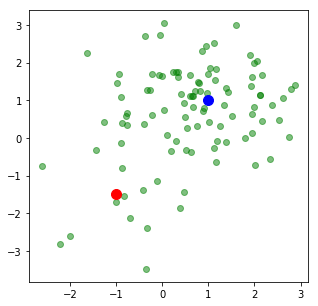

In [15]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_samples = 100
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1]])
ps = np.array([0.2, 0.8])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)

In [16]:
from pymc3.math import logsumexp

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(2)]
#     pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=2)
    pi = pm.Deterministic('w', stick_breaking(beta))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

In [17]:
dy = theano.grad(xs.logpt, pi)
f = theano.function(model.free_RVs, dy, on_unused_input='ignore')

In [18]:
model.free_RVs

[mu_0, mu_1, alpha_log__, beta_logodds__]

In [19]:
model.free_RVs[0].tag.test_value

array([0., 0.])

In [20]:
model.free_RVs[2].tag.test_value

0.0

In [21]:
model.free_RVs[3].tag.test_value

array([0., 0.])

In [22]:
f(np.array([0., 0.]), np.array([5., 0.]), 0., np.array([5., 0.]))

array([100.60819327,  19.47223224])

In [23]:
dy = theano.grad(xs.logpt, alpha, disconnected_inputs='warn')

/usr/local/lib/python3.5/dist-packages/theano/gradient.py:589: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: alpha
  handle_disconnected(elem)
/usr/local/lib/python3.5/dist-packages/theano/gradient.py:615: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: <DisconnectedType>
  handle_disconnected(rval[i])


In [24]:
dy = theano.grad(model.logpt, alpha, disconnected_inputs='warn')

In [25]:
xs.logpt.get_parents()

[Sum{acc_dtype=float64}(Sum{acc_dtype=float64}.0)]

In [26]:
theano.printing.debugprint(xs.logpt)

Sum{acc_dtype=float64} [id A] '__logp_x'   
 |Sum{acc_dtype=float64} [id B] ''   
   |Elemwise{add,no_inplace} [id C] ''   
     |Elemwise{log,no_inplace} [id D] ''   
     | |InplaceDimShuffle{x,0} [id E] ''   
     |   |Sum{axis=[0], acc_dtype=float64} [id F] ''   
     |     |Elemwise{exp,no_inplace} [id G] ''   
     |       |Elemwise{sub,no_inplace} [id H] ''   
     |         |Subtensor{::, :int64:} [id I] ''   
     |         | |Join [id J] ''   
     |         | | |TensorConstant{0} [id K]
     |         | | |InplaceDimShuffle{x,0} [id L] ''   
     |         | | | |Elemwise{add,no_inplace} [id M] ''   
     |         | | |   |InplaceDimShuffle{x} [id N] ''   
     |         | | |   | |Elemwise{log,no_inplace} [id O] ''   
     |         | | |   |   |Subtensor{int64} [id P] ''   
     |         | | |   |     |Elemwise{mul,no_inplace} [id Q] 'w'   
     |         | | |   |     | |ViewOp [id R] 'beta'   
     |         | | |   |     | | |sigmoid [id S] ''   
     |         | | | 

In [27]:
theano.printing.debugprint(model.logpt)

Elemwise{add,no_inplace} [id A] '__logp'   
 |Sum{acc_dtype=float64} [id B] ''   
 | |MakeVector{dtype='float64'} [id C] ''   
 |   |Sum{acc_dtype=float64} [id D] '__logp_mu_0'   
 |   | |Elemwise{switch,no_inplace} [id E] ''   
 |   |   |Elemwise{mul,no_inplace} [id F] ''   
 |   |   | |TensorConstant{1} [id G]
 |   |   | |Elemwise{mul,no_inplace} [id H] ''   
 |   |   |   |TensorConstant{1} [id G]
 |   |   |   |All [id I] ''   
 |   |   |     |Elemwise{gt,no_inplace} [id J] ''   
 |   |   |       |ExtractDiag{offset=0, axis1=0, axis2=1, view=False} [id K] ''   
 |   |   |       | |Cholesky{lower=True, destructive=False, nofail=True} [id L] ''   
 |   |   |       |   |TensorConstant{[[0.1 0. ]..[0.  0.1]]} [id M]
 |   |   |       |InplaceDimShuffle{x} [id N] ''   
 |   |   |         |TensorConstant{0} [id O]
 |   |   |Elemwise{sub,no_inplace} [id P] ''   
 |   |   | |Elemwise{sub,no_inplace} [id Q] ''   
 |   |   | | |Elemwise{mul,no_inplace} [id R] ''   
 |   |   | | | |Elemwise{mul,

In [29]:
inputs([xs.logpt])

[TensorConstant{0},
 beta_logodds__,
 TensorConstant{(1,) of 1},
 TensorConstant{1},
 Constant{-1},
 Constant{0},
 TensorConstant{-0.5},
 TensorConstant{2},
 TensorConstant{6.283185307179586},
 TensorConstant{1.0},
 TensorConstant{[[1. 0.]
  [0. 1.]]},
 TensorConstant{[[-0.32907..03037933]]},
 mu_0,
 TensorConstant{[[1. 0.]
  [0. 1.]]},
 Constant{1},
 TensorConstant{[[1. 0.]
  [0. 1.]]},
 mu_1,
 TensorConstant{[[1. 0.]
  [0. 1.]]},
 Constant{100}]

In [35]:
inputs([model.free_RVs[3].logpt])

[TensorConstant{1},
 beta_logodds__,
 TensorConstant{0},
 TensorConstant{1.0},
 alpha_log__,
 TensorConstant{-inf},
 TensorConstant{1.0},
 TensorConstant{(1,) of -1}]

In [30]:
inputs([model.logpt])

[TensorConstant{1},
 TensorConstant{[[0.1 0. ]..[0.  0.1]]},
 TensorConstant{0},
 TensorConstant{-0.5},
 mu_0,
 Constant{-1},
 TensorConstant{1.8378770664093453},
 TensorConstant{0.5},
 TensorConstant{(2,) of 0.0},
 TensorConstant{2},
 Constant{0},
 TensorConstant{-inf},
 TensorConstant{[[0.1 0. ]..[0.  0.1]]},
 mu_1,
 Constant{-1},
 TensorConstant{(2,) of 0.0},
 Constant{0},
 TensorConstant{-inf},
 alpha_log__,
 TensorConstant{1.0},
 TensorConstant{-inf},
 TensorConstant{-inf},
 TensorConstant{-inf},
 beta_logodds__,
 TensorConstant{-inf},
 TensorConstant{1.0},
 TensorConstant{(1,) of -1},
 TensorConstant{(1,) of 1},
 Constant{-1},
 Constant{0},
 TensorConstant{6.283185307179586},
 TensorConstant{[[1. 0.]
  [0. 1.]]},
 TensorConstant{[[-0.32907..03037933]]},
 TensorConstant{[[1. 0.]
  [0. 1.]]},
 Constant{1},
 TensorConstant{[[1. 0.]
  [0. 1.]]},
 TensorConstant{[[1. 0.]
  [0. 1.]]},
 Constant{100},
 TensorConstant{[]}]